# Experiment 1.

Generates all figures, tables, and statistical comparisons for the __Results / Experiment 1__ section, as well as additional infromation for the __Methods__ section.

In [4]:
rm(list=ls())

In [2]:
library(dplyr)
library(gtools)
library(ggplot2)
library(binom)
library(BayesFactor)
library(lme4)
library(Hmisc)
library(lmerTest)

## 1. Combining files from individual observers into a single table.
Also marking out individual trials and removing duplicate key presses

In [3]:
all.csv.files <- list.files(path= 'Experiment 1', pattern= '*.csv')
results <- data.frame()

for(current.filename in all.csv.files){
    # reading the single participant data
    current.observer <- read.csv2(normalizePath(paste('Experiment 1', current.filename, sep='/')))
    
    # correcting any rounding errors on the RelativeLocation
    current.observer$RelativeLocation[current.observer$RelativeLocation< -1]<- -1
    current.observer$RelativeLocation[current.observer$RelativeLocation> 1]<-  1
    
    # making sure that sfmWidth in numeric, not factor
    current.observer$sfmWidth <- as.numeric(as.character(current.observer$sfmWidth))    
    
    # adding trial index (time between two extremeties)
    current.observer$Trial <- NA
    for(current.block in unique(current.observer$Block)){
        iTrialStartEnd <- which((current.observer$Block==current.block) &  
                                 current.observer$Event %in% c('Block start', 'Trajectory limit', 'Block end'))
        
        for(iCurrentTrial in 1:(length(iTrialStartEnd)-1)){
            current.observer$Trial[iTrialStartEnd[iCurrentTrial]:iTrialStartEnd[iCurrentTrial+1]]<- iCurrentTrial
        }
    }
    
    # removing duplicate percepts, i.e. a participant reporting same percept again
    i.duplicates <- c()
    for(current.block in unique(current.observer$Block)){
        
        current.percept <- 100 # percept code that is definitely different from anything being reported
        for(i.row in which(current.observer$Block==current.block)){
            if (current.observer$Event[i.row]=='Percept'){
                if (current.percept == current.observer$Value[i.row]){
                    i.duplicates <- c(i.duplicates, i.row)
                }
                current.percept <- current.observer$Value[i.row]
            }
        }
    }
    if (length(i.duplicates)>0){
        current.observer <- current.observer[-i.duplicates, ]
    }    
    
    # binding tables
    results <- rbind(results, current.observer)
}

# normalizing sfmWidth by the occluder width
occluder.width <- 150
results$sfmWidth <- results$sfmWidth/occluder.width

# being tidy
rm(list=setdiff(ls(), "results"))

## 2. Computing probability that perception switches after the mid-point (passing behind the occluding object), as a function of the object's width (sfmWidth), factoring in the presence of halo (showHalo) and  sound (playSound)

First, we compute number of percepts reported right after the object passed the midpoint. More specifically, we count trials when participants reported the percept between 200 ms and 800 ms after the midpoint (0.1 to 0.4 in normalized location units)

In [4]:
# computing whether an event occured before or after the mid-point
results$normalized.location <- results$RelativeLocation*results$Direction
results$after.midpoint <- results$normalized.location>0

# counting post midpoint percept onsets (e.i., switches) for each trial
percepts.per.trial <- results %>%
    dplyr::group_by(Observer, Trial, sfmWidth, showHalo, playSound) %>%
    dplyr::summarize(percepts.after.midpoint= sum(Event=='Percept' & normalized.location>0.1 & normalized.location<0.4))
percepts.per.trial <- data.frame(percepts.per.trial)

# computing number of trials with at least on post-mid-point switch and total number of trials
percepts.per.observer <- percepts.per.trial %>%
    dplyr::group_by(Observer, sfmWidth, showHalo, playSound) %>%
    dplyr::summarise(
        trials.with.at.least.one.percept= sum(percepts.after.midpoint>0),
        trials.with.one.percept= sum(percepts.after.midpoint==1),
        trial.count= n(),
        P.switch= trials.with.at.least.one.percept/trial.count)
percepts.per.observer$sfmWidth <- as.numeric(as.character(percepts.per.observer$sfmWidth))
percepts.per.observer <- data.frame(percepts.per.observer)

# logit conversion (for ANOVA)
tiny.correction <- 1e-10
percepts.per.observer$logit.P.switch <- logit(percepts.per.observer$P.switch*(1-2*tiny.correction)+tiny.correction)

Computing group averages for each condition, plus a 95% binomial confidence interval from a beta posterior (see `binom.bayes` function from __binom__ library for details).

In [5]:
percepts.per.condition <- percepts.per.observer %>%
      dplyr::group_by(sfmWidth, showHalo, playSound) %>%
      dplyr::summarise(total.trial.count= sum(trial.count),
                       P.mean= mean(P.switch),
                       P.ci.lower= binom.bayes(round(total.trial.count*mean(P.switch)), total.trial.count)$lower,
                       P.ci.upper= binom.bayes(round(total.trial.count*mean(P.switch)), total.trial.count)$upper)

Plotting group averages for the __Figure 2__ in the manuscript

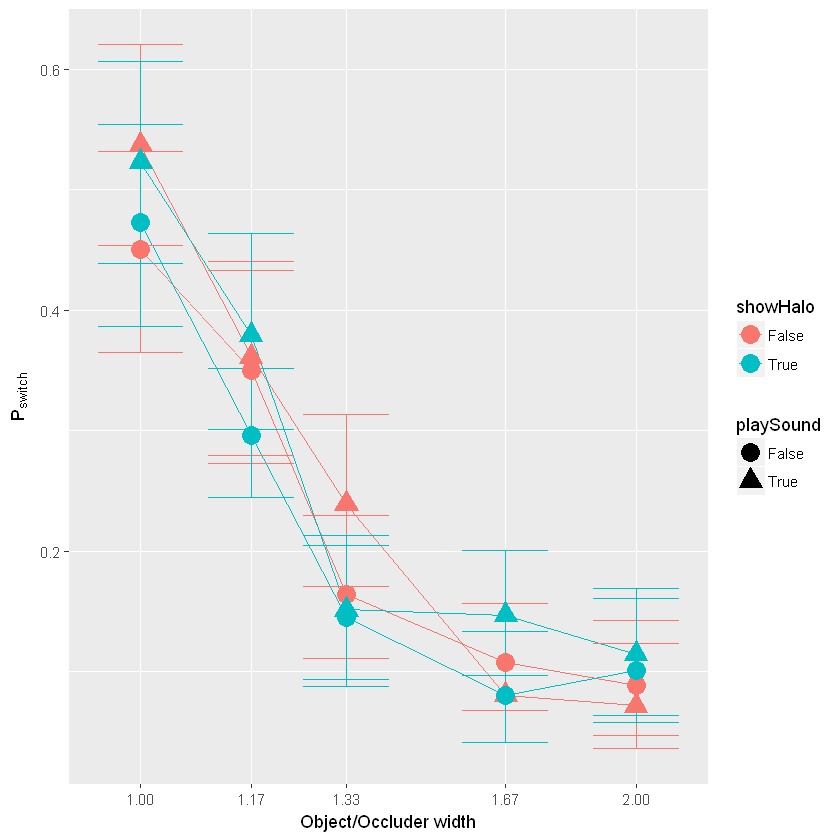

In [6]:
survival.plot <- ggplot(percepts.per.condition, aes(x= sfmWidth, y= P.mean, 
                                                    ymin=P.ci.lower, ymax= P.ci.upper, 
                                                    color= showHalo, shape= playSound))+
    geom_line()+
    geom_errorbar()+
    geom_point(size= 5)+ 
    xlab("Object/Occluder width") + ylab(expression(P[switch]))+
    scale_x_log10(breaks=unique(percepts.per.condition$sfmWidth), 
                  labels = sprintf('%.2f', unique(percepts.per.condition$sfmWidth)),
                  minor_breaks = c())
print(survival.plot)
ggsave(file="Generated figures/Experiment 1 - group averages.pdf", plot= survival.plot, width= 16, height= 12, units = 'cm')

### Using `anovaBF` from `BayesFactor` to identify the best model for the data. 
Column __Bayes Factor__ of the __Table 1__ in the manuscript.

In [7]:
percepts.per.observer$sfmWidth <- as.factor(percepts.per.observer$sfmWidth)
percepts.per.observer$showHalo <- as.factor(percepts.per.observer$showHalo)
percepts.per.observer$Observer <- as.factor(percepts.per.observer$Observer)

switches.aov.bf <-   anovaBF(logit.P.switch ~ sfmWidth + showHalo * playSound + Observer, 
    data= percepts.per.observer,
    whichRandom= 'Observer')
sort(switches.aov.bf, decreasing = TRUE)

Bayes factor analysis
--------------
[1] sfmWidth + Observer                                                                                                                     : 220811.2   ±0.6%
[2] sfmWidth + showHalo + Observer                                                                                                          : 110331.3   ±1.33%
[3] sfmWidth + playSound + Observer                                                                                                         : 36260.29   ±3.08%
[4] sfmWidth + showHalo + playSound + Observer                                                                                              : 18713.76   ±5.25%
[5] sfmWidth + showHalo + sfmWidth:showHalo + Observer                                                                                      : 12741.63   ±1.18%
[6] sfmWidth + showHalo + playSound + showHalo:playSound + Observer                                                                         : 7896.705   ±4.18%
[7] 

### Same analysis but using linear mixed models. 
__Table 1__ in the manuscript.

In [8]:
percepts.per.observer$sfmWidth <- as.numeric(as.character(percepts.per.observer$sfmWidth))

lm.null <- lme4::lmer(P.switch ~ 1 + (1|Observer),
                      data=percepts.per.observer, REML=FALSE)
lm.width <- update(lm.null, .~. + sfmWidth)
lm.sound <- update(lm.width, .~. + playSound)
lm.halo <- update(lm.sound, .~. + showHalo)

lm.sound.width <- update(lm.halo, .~.+playSound:sfmWidth)
lm.halo.width <- update(lm.sound.width, .~. + sfmWidth:showHalo)
lm.sound.halo <- update(lm.halo.width, .~. + playSound:showHalo)

stats::anova(lm.null, lm.width, lm.sound, lm.halo, lm.sound.width, lm.halo.width, lm.sound.halo)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,22.93332,32.82828,-8.466661,16.93332,NA,NA,NA
lm.width,4,-56.03944,-42.84617,32.019718,-64.03944,80.97275866,1,2.288507e-19
lm.sound,5,-55.65844,-39.16686,32.829221,-65.65844,1.61900639,1,2.032304e-01
lm.halo,6,-53.68159,-33.89169,32.840796,-65.68159,0.02314908,1,8.790700e-01
lm.sound.width,7,-52.44060,-29.35238,33.220301,-66.44060,0.75900996,1,3.836385e-01
lm.halo.width,8,-50.78582,-24.39928,33.392908,-66.78582,0.34521566,1,5.568340e-01
lm.sound.halo,9,-48.89892,-19.21406,33.449460,-66.89892,0.11310307,1,7.366386e-01


Computing effect size for the best model that uses only width as a fixed factor

In [9]:
r2.corr.mer <- function(m) {
  lmfit <-  lm(model.response(model.frame(m)) ~ fitted(m))
  summary(lmfit)$r.squared
}
cat(sprintf('Effect size for width-only model R2: %.3f\n', r2.corr.mer(lm.width)))

Effect size for width-only model R2: 0.533


## 3. Analysis of exogenous trigger effectiveness
This information is reported in the __Methods / Displays__ section in the manuscript.

In [13]:
trigger.effectiveness <- results %>%
    dplyr::group_by(Observer, Block, Trial) %>%
    dplyr::summarize(
        has.trigger= sum(Event=='Reverse rotation')>0,
        report.before.midpoint= sum((Event=='Percept')>0 & (after.midpoint==FALSE))>0
    ) %>%
    dplyr::filter(has.trigger==TRUE) %>%
    dplyr::group_by(Observer) %>%
    dplyr::summarize(
        triggered.fraction= sum(report.before.midpoint)/n()
    )

cat(sprintf('Percentage of trials with an effective exogenous trigger: %.2f±%.2f [%.2f..%.2f] (mean±sd [min..max])\n', 
        mean(trigger.effectiveness$triggered.fraction),
        sd(trigger.effectiveness$triggered.fraction),
        min(trigger.effectiveness$triggered.fraction),
        max(trigger.effectiveness$triggered.fraction)))

trigger.effectiveness

Percentage of trials with an effective exogenous trigger: 0.82±0.17 [0.44..0.97] (mean±sd [min..max])


Observer,triggered.fraction
AZM1990w,0.7039474
BPM1997w,0.4417910
CEN2000w,0.6659091
DGR1990w,0.8590909
EGN1994m,0.9431818
HHA1996w,0.9659091
IKB1995w,0.9352273
PHM1988w,0.9136364
SKL1994w,0.9410714
UKS1989m,0.8568182


## 4. Visibility of the the object as a function of the SFM object location
First, loading the shape and retaining only the X-component (other coordinates are not affected by the translational motion along X-axis)

In [14]:
SFM.shape <- read.csv2('SFM shape/bentband-dots[0500].csv', dec = '.')
dot.x <- SFM.shape$X
rm(SFM.shape)

Next, computing locations along the trajectory using:
* trajectory limits 0.2 and 0.8 of total screen width
* 4 second trial duration
* refresh rate was 60 FPS

In [4]:
screen.width.pix <- 1920
trajectory.limits <- screen.width.pix * c(0.2, 0.8)
trial.duration <- 4
screen.FPS <- 60
ticks.count <- trial.duration*screen.FPS+1 # +1 account for the rightmost location, which is technically the first location for the next trial

# linear intervals on 0..1 range
trajectory.ticks <- (0:ticks.count)/ticks.count

# true screen coordinates
trajectory <- trajectory.limits[1]+trajectory.ticks * diff(trajectory.limits)

Now, counting fraction of dots visible at a specific location along the trajectory. Width of the occluding stripe was equal to 150 pixels. This is the __Figure 1F__ in the manuscript.

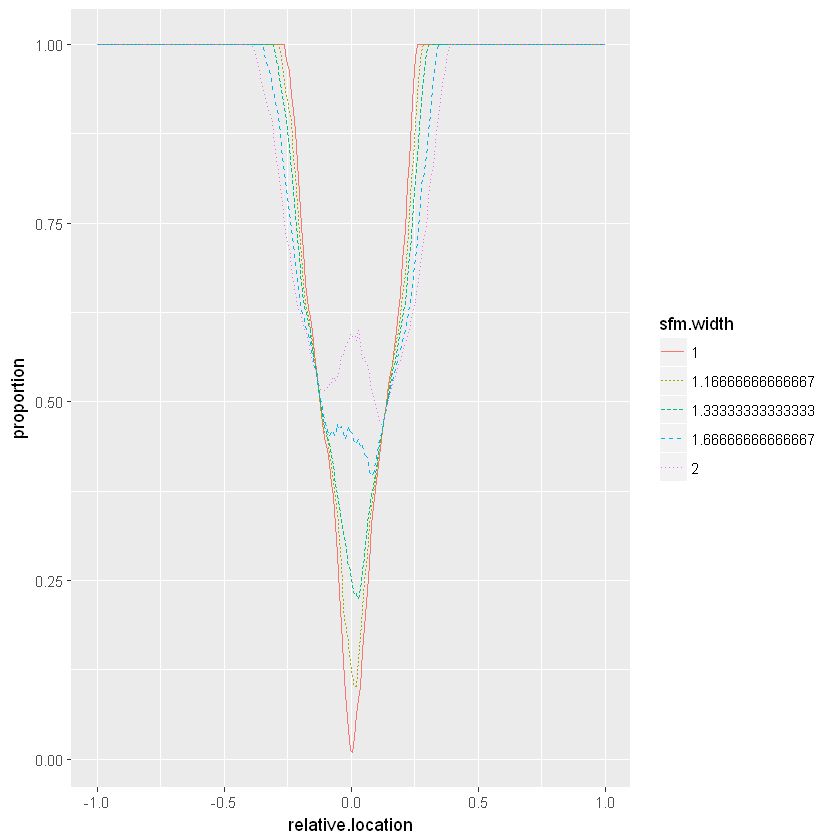

In [16]:
occluder.width <- 150
occluder.limits <- c(-occluder.width/2, occluder.width/2) + screen.width.pix/2
sfm.width <- c(150,175,200,250,300)

visibility <- expand.grid(relative.location= trajectory.ticks*2-1, # this is coordinates in relative location as used elsewhere
                          sfm.width= sfm.width)


compute.dots.visibility <- function(rel.X, width.pix){
    # computing dots location on the screen
    dot.x.pixels <- dot.x * (width.pix/2) + (trajectory.limits[1]  + diff(trajectory.limits) * (rel.X+1)/2.0)
    
    # computing, how many of them were occluded
    return(mean(dot.x.pixels< occluder.limits[1] | dot.x.pixels>occluder.limits[2]))
}

visibility <- visibility %>%
    dplyr::rowwise() %>% 
    dplyr::mutate(proportion= compute.dots.visibility(relative.location, sfm.width))

visibility$sfm.width <- as.factor(visibility$sfm.width/occluder.width)

# plotting visibility
visibility.plot <- ggplot(data= visibility, aes(x= relative.location, y= proportion, color= sfm.width, linetype= sfm.width))+
    geom_line()
print(visibility.plot)

ggsave(file="Generated figures/Experiment 1 - object visibility.pdf", plot= visibility.plot, 
       width= 16, height= 12, units = 'cm')

Time in frames and milliseconds that SFM object was less than 25% visible

In [17]:
invisibility.time <- visibility %>%
    dplyr::ungroup() %>%
    dplyr::group_by(sfm.width) %>%
    dplyr::summarise(frames= sum(proportion<0.25), 
                     time= frames * (1000/screen.FPS))

invisibility.time

sfm.width,frames,time
1,14,233.33333
1.16666666666667,10,166.66667
1.33333333333333,5,83.33333
1.66666666666667,0,0.00000
2,0,0.00000
